# Autoencoders

In [1]:
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.

In [2]:
import os
import sys

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST, CelebA
from torchvision.utils import save_image

import datasets

In [3]:
!gdown 'https://drive.google.com/uc?id=1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ'

Downloading...
From (original): https://drive.google.com/uc?id=1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ
From (redirected): https://drive.google.com/uc?id=1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ&confirm=t&uuid=dac7ed1c-6533-4f05-9c4f-7d9358c62af1
To: /content/celeba.zip
100% 1.31G/1.31G [00:22<00:00, 59.1MB/s]


In [4]:
!unzip /content/celeba.zip

Archive:  /content/celeba.zip
   creating: celeba/
  inflating: celeba/img_align_celeba.zip  
  inflating: __MACOSX/celeba/._img_align_celeba.zip  
  inflating: celeba/list_attr_celeba.txt  
  inflating: __MACOSX/celeba/._list_attr_celeba.txt  
  inflating: celeba/.DS_Store        
  inflating: __MACOSX/celeba/._.DS_Store  
  inflating: celeba/list_bbox_celeba.txt  
  inflating: __MACOSX/celeba/._list_bbox_celeba.txt  
  inflating: celeba/list_landmarks_align_celeba.txt  
  inflating: __MACOSX/celeba/._list_landmarks_align_celeba.txt  
  inflating: celeba/list_landmarks_celeba.txt  
  inflating: __MACOSX/celeba/._list_landmarks_celeba.txt  
  inflating: celeba/list_eval_partition.txt  
  inflating: __MACOSX/celeba/._list_eval_partition.txt  
  inflating: celeba/identity_CelebA.txt  
  inflating: __MACOSX/celeba/._identity_CelebA.txt  


In [5]:
!unzip /content/celeba/img_align_celeba.zip -d /content/celeba/

Streaming output truncated to the last 5000 lines.
 extracting: /content/celeba/img_align_celeba/197600.jpg  
 extracting: /content/celeba/img_align_celeba/197601.jpg  
 extracting: /content/celeba/img_align_celeba/197602.jpg  
 extracting: /content/celeba/img_align_celeba/197603.jpg  
 extracting: /content/celeba/img_align_celeba/197604.jpg  
 extracting: /content/celeba/img_align_celeba/197605.jpg  
 extracting: /content/celeba/img_align_celeba/197606.jpg  
 extracting: /content/celeba/img_align_celeba/197607.jpg  
 extracting: /content/celeba/img_align_celeba/197608.jpg  
 extracting: /content/celeba/img_align_celeba/197609.jpg  
 extracting: /content/celeba/img_align_celeba/197610.jpg  
 extracting: /content/celeba/img_align_celeba/197611.jpg  
 extracting: /content/celeba/img_align_celeba/197612.jpg  
 extracting: /content/celeba/img_align_celeba/197613.jpg  
 extracting: /content/celeba/img_align_celeba/197614.jpg  
 extracting: /content/celeba/img_align_celeba/197615.jpg  
 extr

## Autoencoders

Autoencoder - це тип нейронної мережі, який використовується для зменшення розмірності даних або для відновлення вхідних даних з меншою кількістю вимірів (зазвичай меншою кількістю нейронів) в прихованому шарі. Основна ідея за автоенкодером полягає в тому, щоб навчити мережу представляти вхідні дані в компактному представленні, що називається прихованим представленням, і відтворювати вхідні дані з цього прихованого представлення. Важливою особливістю автоенкодерів є те, що вони вчаться без нагляду, тобто мережа навчається без парних вхідних-вихідних даних. (unsupervised learning) <br><br>

Мета навчання автокодувальника - навчити енкодер ігнорувати незначущі дані вхідного сигналу та зберегти лише найважливіші дані. Це дозволяє автокодувальнику відтворювати вхідний сигнал із меншою кількістю даних, ніж було на початку. Іншими словами, метою автокодувальника є вивчення низьковимірного представлення для більш вимірних даних, зазвичай для зменшення розмірності, шляхом навчання мережі захопленню найважливіших частин вхідного зображення. <br>
Основна особливість Autoencoder це те, що він реконструює наш вхідний сигнал, маючи лише його стиснуту версію. <br><br>

Autoencoder навчаються кодувати вхідні дані, наприклад зображення, у менший вектор ознак, а потім реконструювати його за допомогою другої нейронної мережі, яка називається декодером. <br>
Вектор ознак називають «вузьким місцем» мережі, оскільки ми прагнемо стиснути вхідні дані в меншу кількість ознак. <br>
Ця властивість корисна в багатьох програмах, зокрема для стиснення даних або порівняння зображень на рівні пікселів. <br>
Окрім вивчення структури автокодувальника, ми також побачимо оператор «деконволюції» (або транспонованої згортки) у дії для збільшення карт функцій у висоту та ширину. Такі мережі деконволюції необхідні скрізь, коли ми починаємо з невеликого вектора ознак і потребуємо виведення зображення повного розміру (наприклад, у VAE, GAN або додатках із надвисокою роздільною здатністю).

Autoencoder складається з двох основних частин: енкодера та декодера. Енкодер отримує вхідний сигнал і перетворює його в більш компактне представлення, яке називається прихованим простором (latent space). Декодер отримує прихований простір ознак і перетворює його назад у вхідний сигнал.

Автокодувальники мають широкий спектр застосувань, зокрема:

- Зниження розмірності даних. Автокодувальники можуть використовуватися для зменшення розмірності даних, не втрачаючи при цьому важливої інформації. Це може бути корисно для прискорення обробки даних та для спрощення навчання інших моделей машинного навчання.
- Вилучення ознак. Автокодувальники можуть використовуватися для вилучення ознак із даних. Ці ознаки можуть потім використовуватися для інших завдань машинного навчання, таких як класифікація або регресія.
- Обробка шуму. Автокодувальники можуть використовуватися для видалення шуму з даних. Це може бути корисно для покращення точності інших моделей машинного навчання.
- Генерація даних. Автокодувальники можуть використовуватися для генерації нових даних, схожих на дані, на яких вони були навчені. Це може бути корисно для створення нових творчих контентів.

### Architecture

Автоенкодери складаються з 3 частин:
- **Encoder:** модуль, який стискає вхідні дані набору train-validate-test у закодоване представлення, яке зазвичай на кілька порядків менше, ніж вхідні дані.
- **Bottleneck:** Модуль, який містить стислі представлення знань і тому є найважливішою частиною мережі.
- **Decoder:** модуль, який допомагає мережі «розпаковувати» представлення знань і реконструювати дані з їхньої закодованої форми. Потім результат порівнюється з базовою правдою.

Архітектура в цілому виглядає приблизно так:

<img src='https://drive.google.com/uc?id=1UjEggCdljzEKEMZ6W7B-4trWdqIO6nhy'>

### The relationship between the Encoder, Bottleneck, and Decoder

#### Encoder

Encoder — це набір згорткових блоків, за якими йдуть модулі об’єднання, які стискають вхідні дані моделі в компактну секцію, яка називається вузьким місцем. <br>
За вузьким місцем слідує декодер, який складається з серії модулів підвищення дискретизації, щоб повернути стиснуту функцію у форму зображення. У випадку простих автоенкодерів очікується, що вихідні дані будуть такими ж, як і вхідні дані, зі зниженим шумом. <br>
Однак для варіаційних автоенкодерів це абсолютно нове зображення, сформоване з інформацією про модель, яка була надана як вхідна інформація. <br>

Енкодер - це частина архітектури автокодувальника, яка відповідає за стиснення вхідного сигналу в більш компактне представлення, яке називається прихованим простором.

Енкодер зазвичай складається з одного або кількох шарів згортки. Шари згортки працюють шляхом застосування фільтрів до вхідного сигналу. Фільтри збирають інформацію з сусідніх пікселів або точок та створюють нові дані.

Наприклад, якщо вхідний сигнал є зображенням розміром 28x28 пікселів, то енкодер може використовувати один шар згортки з фільтром розміром 3x3 пікселів. Фільтр буде використовувати інформацію з 9 пікселів вхідного сигналу для створення нових даних.

Енкодер може використовувати кілька шарів згортки для подальшого стиснення вхідного сигналу. Чим більше шарів згортки використовується, тим меншим буде прихований простір.

Приховний простір зазвичай має розмір, який набагато менше розміру вхідного сигналу.

**Типи енкодерів**

Існує кілька різних типів енкодерів, які можуть використовуватися в автоенкодерах. Ось кілька прикладів:

* **Стандартний енкодер**. Стандартний енкодер використовує лише шари згортки.
* **Конкретний енкодер**. Конкретний енкодер використовує шари згортки та шари регулярізації, такі як шари розрідження або шари контрактивності.
* **Варіаційний енкодер**. Варіаційний енкодер використовує шари згортки та шари, які дозволяють енкодеру отримувати розподіл прихованого простору.

**Вибір типу енкодера**

Вибір типу енкодера залежить від конкретних завдань, для яких використовується автоенкодер. Стандартний енкодер є хорошим вибором для простих завдань, таких як зниження розмірності даних. Конкретний енкодер може бути кращим вибором для завдань, які вимагають більшої точності. Варіаційний енкодер може бути кращим вибором для завдань, які вимагають генерації нових даних.

Енкодер є важливою частиною архітектури автоенкодера. Він відповідає за стиснення вхідного сигналу в більш компактне представлення, яке може використовуватися для різних завдань машинного навчання.

#### Bottleneck

Найважливіша частина нейронної мережі, і за іронією долі найменша, є вузьким місцем. Вузьке місце існує, щоб обмежити потік інформації до декодера від енкодера, таким чином дозволяючи проходити лише найважливішій інформації. <br>
Оскільки вузьке місце сконструйовано таким чином, щоб у ньому було захоплено максимум інформації, якою володіє зображення, ми можемо сказати, що вузьке місце допомагає нам сформувати *уявлення* про вхідні дані. <br>
Таким чином, структура енкодера-декодера допомагає нам отримати максимум із зображення у формі даних і встановити корисні кореляції між різними вхідними даними в мережі. <br>

Як правило, запам’ятайте наступне: чим менше вузьке місце, тим менший ризик перенавчання. <br>
Однак дуже невеликі вузькі місця обмежуватимуть обсяг інформації, яку можна зберегти, що збільшує ймовірність вислизання важливої інформації через шари об’єднання енкодера. <br>

**Шар Bottleneck** - це шар в автокодувальнику, який відповідає за перехід від вхідного сигналу до прихованого простору. Шар Bottleneck зазвичай має меншу кількість нейронів, ніж вхідний або вихідний шар. Це допомагає стиснути вхідний сигнал, зберігаючи при цьому важливу інформацію.

Шар Bottleneck може бути реалізований різними способами. Один із поширених способів - використовувати шар згортки з фільтром розміру 1x1. Цей тип шару не змінює розмір даних, але він може зменшити кількість нейронів, обробляючи дані в одному вимірі за раз.

Інший поширений спосіб реалізації шару Bottleneck - використовувати шар згорткової мережі з шарами 1x1, які чергуються з шарами 3x3. Цей тип шару може зменшити кількість нейронів, зберігаючи при цьому важливу інформацію.

**Роль шару Bottleneck**

Шар Bottleneck відіграє важливу роль в автоенкодері. Він відповідає за те, щоб прихований простір був достатньо компактним, щоб його можна було легко зберегти та обробляти. Однак він також повинен бути достатньо великим, щоб містити важливу інформацію з вхідного сигналу.

**Вибір розміру шару Bottleneck**

Розмір шару Bottleneck є важливим параметром, який слід налаштувати для конкретного завдання. Якщо розмір шару Bottleneck занадто малий, то прихований простір може бути недостатньо великим, щоб містити важливу інформацію з вхідного сигналу. Якщо розмір шару Bottleneck занадто великий, то прихований простір може бути занадто великим, щоб його можна було легко зберегти та обробляти.

Шар Bottleneck є важливою частиною архітектури автоенкодера. Він відповідає за перехід від вхідного сигналу до прихованого простору, зберігаючи при цьому важливу інформацію.

#### Decoder

Нарешті, декодер — це набір блоків підвищення дискретизації та згортки, який реконструює вихід вузького місця. <br>
Оскільки вхідні дані для декодера є стислим представленням знань, декодер виконує роль «розпаковувача» і створює зображення з його прихованих атрибутів.

**Декодер** - це частина архітектури автокодувальника, яка відповідає за відтворення вхідного сигналу з прихованого простору. Декодер зазвичай складається з одного або кількох шарів розгортки. Шари розгортки працюють шляхом застосування фільтрів до прихованого простору. Фільтри створюють нові дані з інформації, яка міститься в прихованому просторі.

Декодер може використовувати кілька шарів розгортки для подальшого відтворення вхідного сигналу. Чим більше шарів розгортки використовується, тим більш схожим буде відтворений сигнал на вхідний сигнал.

**Типи декодерів**

Існує кілька різних типів декодерів, які можуть використовуватися в автоенкодерами. Ось кілька прикладів:

* **Стандартний декодер**. Стандартний декодер використовує лише шари розгортки.
* **Конкретний декодер**. Конкретний декодер використовує шари розгортки та шари регулярізації.
* **Варіаційний декодер**. Варіаційний декодер використовує шари розгортки та шари, які дозволяють декодеру отримувати розподіл відтвореного сигналу.

**Вибір типу декодера**

Вибір типу декодера залежить від конкретних завдань, для яких використовується автоенкодер. Стандартний декодер є хорошим вибором для простих завдань, таких як відтворення зображень. Конкретний декодер може бути кращим вибором для завдань, які вимагають більшої точності. Варіаційний декодер може бути кращим вибором для завдань, які вимагають генерації нових даних.

Декодер є важливою частиною архітектури автокодувальника. Він відповідає за відтворення вхідного сигналу з прихованого коду.

### Training Autoencoders

Вам потрібно встановити 4 гіперпараметри перед навчанням автоенкодера:

1. **Розмір прихованого простору:** Розмір прихованого простору або розмір вузького місця є найважливішим гіперпараметром, який використовується для налаштування автоенкодера. Розмір вузького місця визначає, наскільки дані потрібно стиснути. Це також може діяти як регуляризаційний термін.
2. **Кількість шарів:** Як і в усіх нейронних мережах, важливим гіперпараметром для налаштування автоенкодерів є глибина енкодера та декодера. У той час як більша глибина збільшує складність моделі, менша глибина швидше обробляється.
3. **Кількість вузлів на шар:** Кількість вузлів на шар визначає ваги, які ми використовуємо для кожного шару. Як правило, кількість вузлів зменшується з кожним наступним шаром в автоенкодері, оскільки вхідні дані для кожного з цих шарів стають меншими між шарами.
4. **Втрати при реконструкції:** Функція втрат, яку ми використовуємо для навчання автоенкодера, сильно залежить від типу вхідних і вихідних даних, до яких ми хочемо адаптувати автоенкодер. Якщо ми працюємо з даними зображення, найпопулярнішими функціями втрати для реконструкції є **MSE Loss** і **L1 Loss**. Якщо входи та виходи знаходяться в діапазоні [0,1], як у MNIST, ми також можемо використовувати **двійкову перехресну ентропію** як втрати при реконструкції.

### Types of Autoencoders

Ідея автоенкодерів для нейронних мереж не нова.

Перші заявки відносяться до 1980-х років. Концепція автоенкодера, яка спочатку використовувалася для зменшення розмірності та вивчення функцій, розвивалася протягом багатьох років і зараз широко використовується для вивчення генеративних моделей даних.

Ось п’ять популярних автоенкодерів:
1. **Неповні автокодери (Undercomplete autoencoders)**
2. **Розріджені автокодери (Sparse autoencoders)**
3. **Контракційні автокодери (Contrastive Autoencoders)**
4. **Автокодери з шумозаглушенням (Denoising Autoencoders)**
5. **Варіаційні автокодери (для генеративного моделювання) (Variational Autoencoders)**

### Undercomplete autoencoders

Undercomplete autoencoders є одним із найпростіших типів autoencoders.

Спосіб його роботи дуже простий — undercomplete autoencoders приймає зображення та намагається передбачити те саме зображення як вихід, таким чином реконструюючи зображення зі стиснутої області вузького місця.

Undercomplete autoencoders справді не контролюються, оскільки вони не приймають жодної форми мітки.

Основним використанням подібних autoencoders є створення прихованого простору або вузького місця, яке утворює стиснуту заміну вхідних даних і може бути легко розпаковано назад за допомогою мережі, коли це необхідно.

Цю форму стиснення даних можна моделювати як форму **зменшення розмірності**.

<center><img src="https://drive.google.com/uc?id=1UhZ_J90GWokChhGWgpHQZMWnFZhaSRDL"></center>


<center>
    <i>
        З фіксованою кількістю навчальних вибірок середня (очікувана) прогностична потужність класифікатора або регресора спочатку зростає, оскільки кількість використовуваних параметрів або ознак збільшується, але після досягнення певної розмірності вона починає погіршуватися замість постійного покращення.
    </i>
</center>


Undercomplete autoencoders можуть навчатися нелінійним зв’язкам і, отже, краще працювати у зменшенні розмірності.

Ця форма нелінійного зменшення розмірності, коли автокодер вивчає нелінійний різновид, також називається *розбірним навчанням*.

По суті, якщо ми видаляємо всі нелінійні активації з Undercomplete autoencoders та використовуємо лише лінійні шари, ми зменшуємо Undercomplete autoencoders таким чином.

Функція втрати, яка використовується для навчання undercomplete autoencoders, називається *втратою реконструкції*, оскільки це перевірка того, наскільки добре зображення було реконструйовано з вхідних даних.

Хоча втрати при реконструкції можуть бути будь-якими залежно від вхідних і вихідних даних, ми використовуватимемо втрати L1, щоб відобразити термін (також званий *нормальними втратами*), представлений таким чином:

$$ L = | x - \hat{x} | $$

Де $\hat{x}$ представляє прогнозований вихід, а $x$ представляє основну правду.

Оскільки функція втрат не має явного терміну регуляризації, єдиним способом гарантувати, що модель не запам’ятовує вхідні дані, є регулювання розміру вузького місця та кількості прихованих шарів у цій частині мережі — архітектури.

In [ ]:
def to_img(x):
    # Закріплюємо значення тензора x між 0 і 1, щоб вони відповідали діапазону кольорів зображення.
    x = x.clamp(0, 1)
    # Перетворюємо тензор x у зображення розміром (batch_size, канали, висота, ширина).
    x = x.view(x.size(0), 3, 32, 32)
    return x

In [ ]:
device = "cuda"  # Визначаємо пристрій, на якому буде виконуватися обчислення.
batch_size = 128  # Визначаємо розмір партії даних для обробки.

# Визначаємо трансформації зображень для підготовки даних.
img_transform = transforms.Compose([
    transforms.ToTensor(),  # Перетворюємо зображення у тензор.
    # transforms.Normalize([0.5], [0.5])  # Нормалізуємо значення пікселів зображень.
])

# Завантажуємо CIFAR-10 dataset з використанням визначених трансформацій.
dataset = CIFAR10('./data', transform=img_transform, download=True)

# Створюємо DataLoader для подачі даних у модель партіями заданого розміру з випадковим перемішуванням.
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 52627926.73it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
len(dataset)

50000

In [ ]:
dataset[0][0].shape

torch.Size([3, 32, 32])

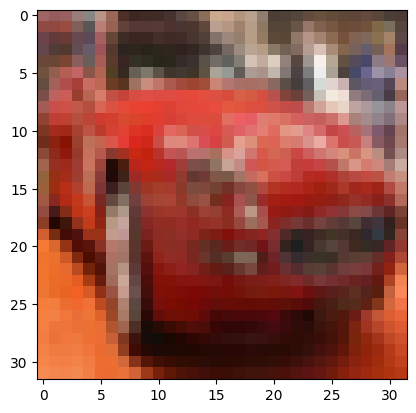

In [ ]:
plt.imshow(dataset[5][0].permute(1, 2, 0).numpy());

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Визначаємо енкодер та декодер за допомогою послідовних шарів нейронних мереж.
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=3, padding=1),  # Згортковий шар з 3 вхідними каналами та 16 вихідними, з кроком 3 та згорткою 3x3.
            nn.ReLU(True),  # Функція активації ReLU.
            nn.MaxPool2d(2, stride=2),  # Пулінговий шар максимального зведення з ядром розміром 2x2 та кроком 2.
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # Згортковий шар з 16 вхідними каналами та 8 вихідними, з кроком 2 та згорткою 3x3.
            nn.ReLU(True),  # Функція активації ReLU.
            nn.MaxPool2d(2, stride=1)  # Пулінговий шар максимального зведення з ядром розміром 2x2 та кроком 1.
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # Транспонований згортковий шар з 8 вхідними каналами та 16 вихідними, з кроком 2 та згорткою 3x3.
            nn.ReLU(True),  # Функція активації ReLU.
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # Транспонований згортковий шар з 16 вхідними каналами та 8 вихідними, з кроком 3 та згорткою 5x5.
            nn.ReLU(True),  # Функція активації ReLU.
            nn.ConvTranspose2d(8, 3, 6, stride=2, padding=1),  # Транспонований згортковий шар з 8 вхідними каналами та 3 вихідними, з кроком 2 та згорткою 6x6.
            nn.Sigmoid()  # Функція активації сигмоїда для забезпечення значень пікселів у діапазоні [0, 1].
        )

    def forward(self, x):
        # Прямий прохід через енкодер та декодер.
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = AutoEncoder().to(device)
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # weight_decay=1e-5

epoch [1/40], loss:0.0299


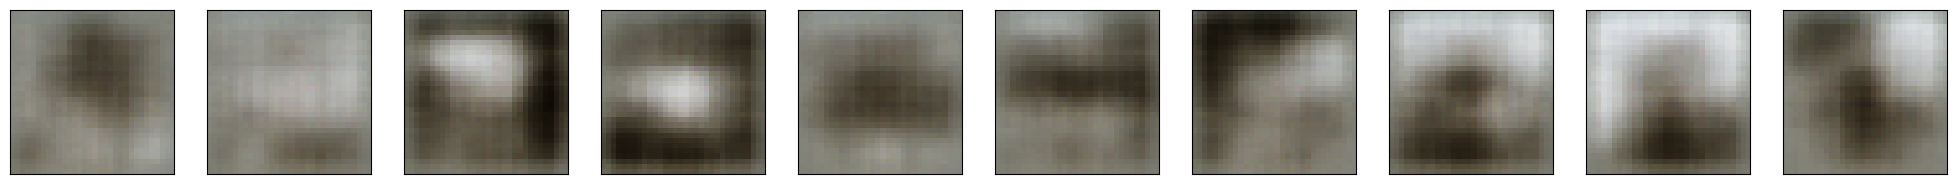

epoch [2/40], loss:0.0262
epoch [3/40], loss:0.0247
epoch [4/40], loss:0.0250
epoch [5/40], loss:0.0238


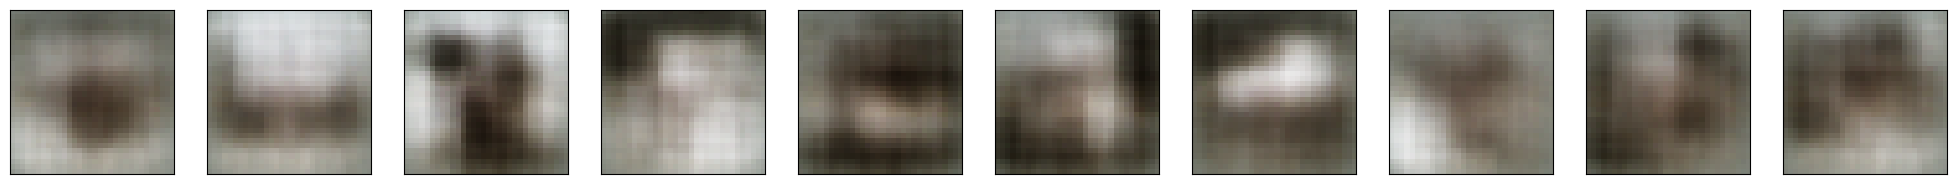

epoch [6/40], loss:0.0254
epoch [7/40], loss:0.0233
epoch [8/40], loss:0.0207
epoch [9/40], loss:0.0214


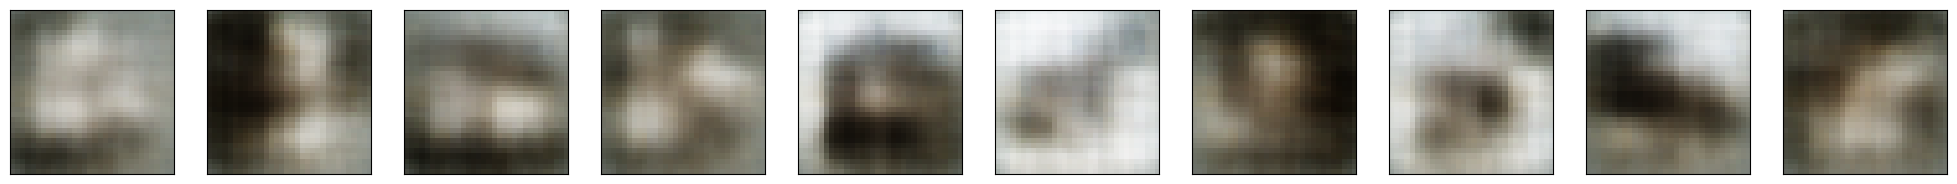

epoch [10/40], loss:0.0217
epoch [11/40], loss:0.0233
epoch [12/40], loss:0.0202
epoch [13/40], loss:0.0212


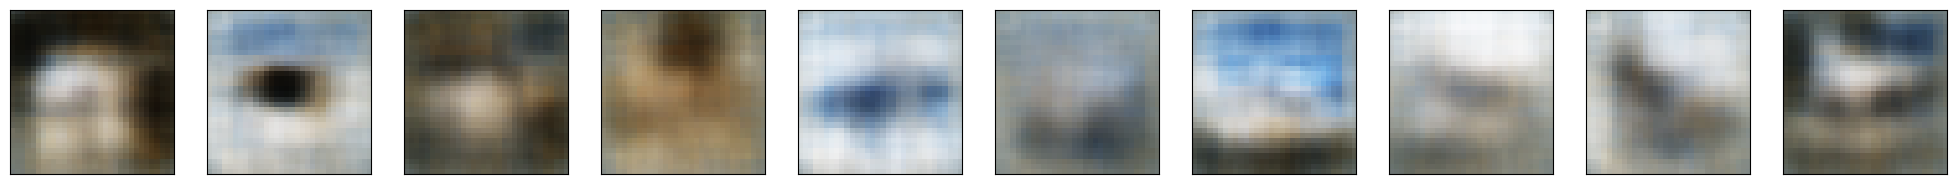

epoch [14/40], loss:0.0180
epoch [15/40], loss:0.0190
epoch [16/40], loss:0.0207
epoch [17/40], loss:0.0173


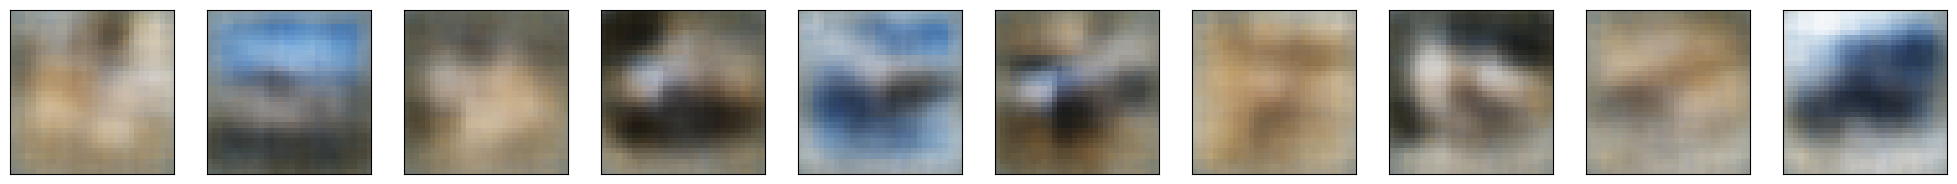

epoch [18/40], loss:0.0204
epoch [19/40], loss:0.0194
epoch [20/40], loss:0.0175
epoch [21/40], loss:0.0185


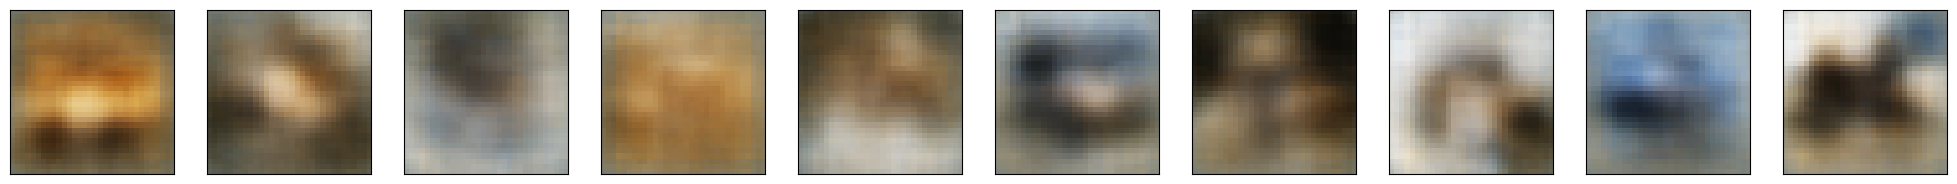

epoch [22/40], loss:0.0169
epoch [23/40], loss:0.0201
epoch [24/40], loss:0.0189
epoch [25/40], loss:0.0197


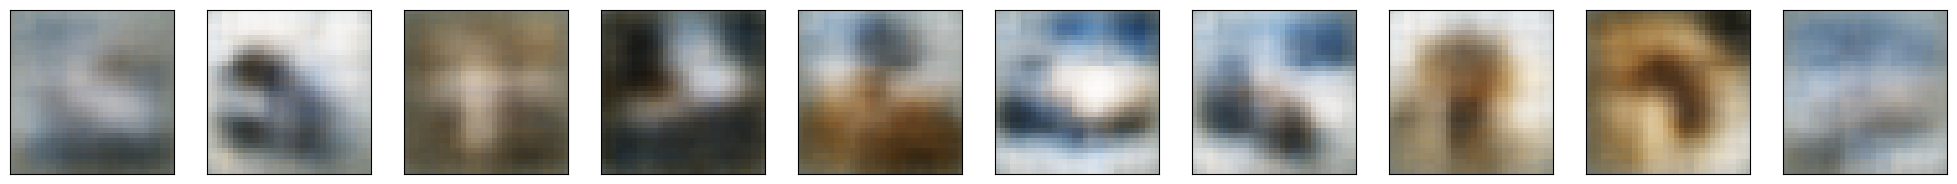

epoch [26/40], loss:0.0172
epoch [27/40], loss:0.0188
epoch [28/40], loss:0.0193
epoch [29/40], loss:0.0178


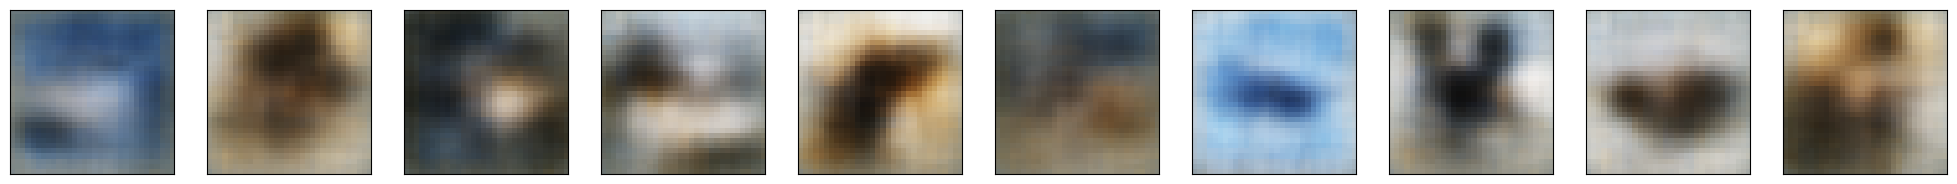

epoch [30/40], loss:0.0185
epoch [31/40], loss:0.0187
epoch [32/40], loss:0.0191
epoch [33/40], loss:0.0167


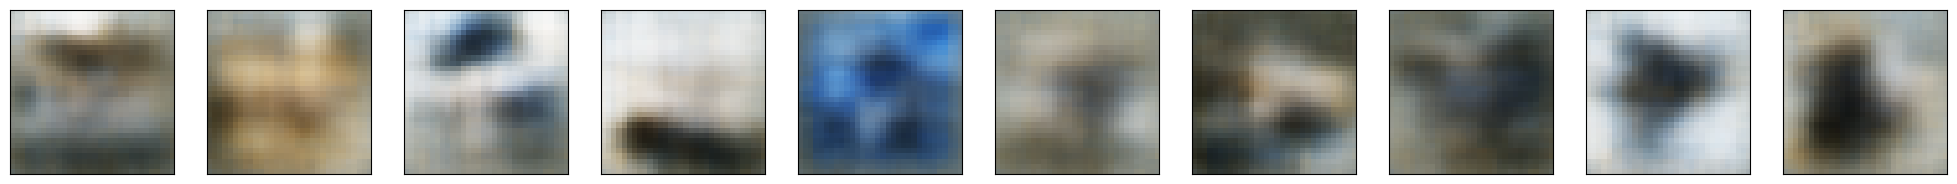

epoch [34/40], loss:0.0174
epoch [35/40], loss:0.0178
epoch [36/40], loss:0.0158
epoch [37/40], loss:0.0177


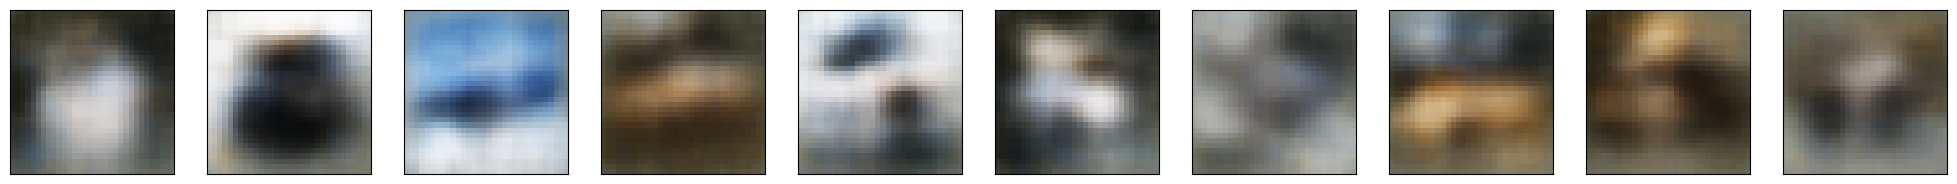

epoch [38/40], loss:0.0191
epoch [39/40], loss:0.0172
epoch [40/40], loss:0.0171


In [ ]:
num_epochs = 40  # Визначаємо кількість епох навчання.

for epoch in range(num_epochs):
    # Проходимося по даним у кожній епохі через DataLoader.
    for data in dataloader:
        img, _ = data
        # img = img.view(img.size(0), -1)  # Опціонально: перетворюємо зображення у вектор, якщо потрібно.
        img = img.to(device)  # Переміщуємо дані на визначений пристрій.

        # ===================forward=====================
        output = model(img)  # Здійснюємо прямий прохід через модель.
        loss = criterion(output, img)  # Обчислюємо втрати.

        # ===================backward====================
        optimizer.zero_grad()  # Обнуляємо градієнти попередніх кроків.
        loss.backward()  # Обчислюємо градієнти втрат.
        optimizer.step()  # Виконуємо оптимізаційний крок.

    # ===================log========================
    # Виводимо інформацію про втрати на кожній епохі.
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))

    if epoch % 4 == 0:
        # Опціонально: візуалізуємо відновлені зображення після кожної четвертої епохи.
        pic = to_img(output.detach().cpu())  # Перетворюємо тензор зображень у зображення.
        n_images = 10  # Кількість зображень для відображення.
        fig, axes = plt.subplots(nrows=1, ncols=n_images, sharex=True, sharey=True, figsize=(25, 4))
        for i in range(n_images):
            ax = axes[i]
            sample_image = pic[i].permute(1, 2, 0).detach().cpu().numpy()  # Перетворюємо тензор у масив NumPy.
            ax.imshow(sample_image)  # Відображаємо зображення.
            ax.get_xaxis().set_visible(False)  # Вимикаємо підписи по осі x.
            ax.get_yaxis().set_visible(False)  # Вимикаємо підписи по осі y.
        plt.show()  # Показуємо зображення.


### Sparse autoencoders

Sparse autoencoders подібні до недоповнених автоенкодерів тим, що вони використовують те саме зображення як вхідні дані та базову правду. Однак засоби, за допомогою яких регулюється кодування інформації, істотно відрізняються.

У той час як недоповнені автоенкодери регулюються та налаштовуються шляхом регулювання розміру вузького місця, розріджений автоенкодер регулюється зміною кількості вузлів на кожному прихованому рівні.

Оскільки неможливо спроектувати нейронну мережу, яка має гнучку кількість вузлів на прихованих шарах, розріджені автоенкодери працюють, штрафуючи активацію деяких нейронів у прихованих шарах.

Іншими словами, функція втрат має член, який обчислює кількість нейронів, які були активовані, і забезпечує штраф, який прямо пропорційний цьому.

Цей штраф, який називається функцією розрідженості, не дає нейронній мережі активувати більше нейронів і служить регуляризатором.

У той час як типові регуляризатори працюють, створюючи покарання за розміром ваг у вузлах, регуляризатор розрідженості працює, створюючи покарання за кількістю активованих вузлів.

Ця форма регуляризації дозволяє мережі мати вузли в прихованих шарах, призначені для пошуку конкретних особливостей у зображеннях під час навчання та розглядання проблеми регуляризації як проблеми, окремої від проблеми прихованого простору.

Таким чином, ми можемо встановити приховану розмірність простору у вузькому місці, не турбуючись про регулярізацію.

Є два основних способи, якими член регуляризатора розрідженості може бути включений у функцію втрат.

**L1 Loss:** тут ми додаємо величину регуляризатора розрідженості, як це робимо для загальних регулязаторів:

$$ L = | x - \hat{x} | + \lambda \sum_i | a_i^{(h)} | $$

Де $h$ представляє прихований шар, $i$ представляє зображення в міні-пакеті, а $a$ представляє активацію.

**KL-Divergence (Kullback-Leibler Divergence):** У цьому випадку ми розглядаємо активації над колекцією зразків одночасно, а не підсумовуємо їх, як у методі L1 Loss. Ми обмежуємо середню активацію кожного нейрона в цій колекції.

Розглядаючи ідеальний розподіл як розподіл Бернуллі, ми включаємо розбіжність KL у втрату, щоб зменшити різницю між поточним розподілом активацій та ідеальним (Бернуллі) розподілом:

$$ L = | x - \hat{x} | + \lambda \sum_j \operatorname{KL} (\rho || \hat{\rho}_j)  $$

Де $\hat{\rho}_j = \frac{1}{m} \sum_i [ a_i^{(h)} (x) ]$ і $j$ позначають конкретний нейрон для шару $h$ і колекції $m$ зразків, кожен з яких позначено як $x$.

**[An example of sparce autoencoder you can find here.](https://debuggercafe.com/sparse-autoencoders-using-kl-divergence-with-pytorch/)**

### Contrastive Autoencoders


Як і інші автоенкодери, Contrastive Autoencoders виконують завдання вивчення представлення зображення, пропускаючи його через вузьке місце та реконструюючи його в декодері.

Contrastive Autoencoders також має термін регуляризації, щоб запобігти засвоєнню мережею функції ідентифікації та відображення вхідних даних у вихідні дані.

Contrastive Autoencoders працюють на основі того, що подібні вхідні дані повинні мати схоже кодування та подібне представлення прихованого простору. Це означає, що прихований простір не повинен змінюватися на величезну величину для незначних варіацій у вхідних даних.

Щоб навчити модель, яка працює разом з цим обмеженням, ми повинні переконатися, що похідні активації прихованого шару малі по відношенню до вхідних даних.

Математично:

$$ \frac{\partial h}{\partial x} $$

Де $h$ представляє прихований шар, а $x$ представляє вхідні дані.

Важливо зауважити, що у функції втрат (утвореної з норми похідних і втрат від реконструкції) є те, що два терміни суперечать один одному.

У той час як втрата реконструкції вимагає, щоб модель виявила відмінності між двома вхідними даними та спостерігала варіації даних, норма Фробеніуса похідних говорить, що модель повинна мати можливість ігнорувати варіації вхідних даних.

Поєднання цих двох суперечливих умов в одну функцію втрат дає нам змогу навчити мережу, де приховані рівні тепер охоплюють лише найважливішу інформацію. Ця інформація необхідна для розділення зображень і ігнорування інформації, яка є недискримінаційною за своєю природою, а отже, не важливою.

Функцію загальних втрат можна математично виразити так:

$$ L = | x - \hat{x} | + \lambda \sum_i \lVert \bigtriangledown_x a_i^{(h)} (x) \rVert^2 $$

Де $h$ — прихований шар, для якого розраховується градієнт і представлений відносно вхідних даних $x$ як $\bigtriangledown_x a_i^{(h)} (x)$.

Градієнт підсумовується за всіма навчальними зразками, і береться [норма Фробеніуса](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm).


### Denoising Autoencoders

Як випливає з назви, автоенкодери з усуненням шумів є автоенкодерами, які видаляють шум із зображення.

На відміну від автоенкодерів, які ми вже розглядали, це перший у своєму роді, який не має вхідного зображення як основної правди.

У автоенкодерах із шумом ми подаємо зашумлену версію зображення, куди шум додано за допомогою цифрових змін. Зображення з шумом подається на архітектуру енкодера-декодера, а вихід порівнюється з основним істинним зображенням.

<center><img src="https://drive.google.com/uc?id=1UhwdbG6Gy6PdXpMgiGp-cac1AH9NYUZQ"></center>


Автоматичний кодувальник усуває шум, вивчаючи представлення вхідного сигналу, де шум можна легко відфільтрувати.

Хоча видалення шуму безпосередньо із зображення здається складним, автоенкодер виконує це шляхом відображення вхідних даних у різновид нижчої розмірності (як у недоповнених автоенкодерах), де фільтрація шуму стає набагато легшою.

По суті, шумопоглинаючі автоенкодери працюють за допомогою нелінійного зменшення розмірності. Функція втрат, як правило, використовується в цих типах мереж, це втрати L2 або L1.

In [ ]:
device = "cuda"
batch_size = 128

img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5])
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        ## encoder layers
        # Визначаємо згорткові шари для кодера з вказаною кількістю входів, виходів та параметрами.
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        # Визначаємо транспоновані згорткові шари для декодера з вказаною кількістю входів, виходів та параметрами.
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x):
        ## encode
        # Прямий прохід через кодер з послідовним застосуванням згорткових шарів та пулінгових шарів.
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        #
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        #
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation

        ## decode
        # Прямий прохід через декодер з послідовним застосуванням транспонованих згорткових шарів та функції активації.
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        x = torch.sigmoid(self.conv_out(x))  # Використовуємо сигмоїд для отримання значень пікселів у діапазоні [0, 1].

        return x

In [ ]:
model = DenoisingAutoEncoder().to(device)
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  #  weight_decay=1e-5

In [ ]:
num_epochs = 40  # Визначаємо кількість епох навчання.
noise_factor = 0.3  # Визначаємо фактор шуму.

for epoch in range(num_epochs):
    train_loss = 0.0  # Ініціалізуємо втрати для навчання на поточній епохі.

    for data in dataloader:
        images, _ = data
        images = images.to(device)  # Переміщуємо зображення на пристрій.

        # Додаємо випадковий шум до вхідних зображень.
        noisy_imgs = images + noise_factor * torch.randn(*images.shape, device=device)
        # Обмежуємо значення пікселів у діапазоні [0, 1].
        noisy_imgs = torch.clip(noisy_imgs, 0., 1.)

        optimizer.zero_grad()  # Обнуляємо градієнти попередніх кроків.
        outputs = model(noisy_imgs)  # Викликаємо модель для обробки шумних зображень.

        # "Метою" залишається оригінальне, нешумне зображення.
        loss = criterion(outputs, images)  # Обчислюємо втрати.
        loss.backward()  # Обчислюємо градієнти втрат.
        optimizer.step()  # Виконуємо оптимізаційний крок.

        train_loss += loss.item() * images.size(0)  # Додаємо втрати на поточному пакеті.

    train_loss = train_loss / len(dataloader)  # Обчислюємо середні втрати для епохи.
    print("Epoch {:2d}| \tTraining Loss: {:.6f}".format(epoch + 1, train_loss))  # Виводимо втрати для поточної епохи.


Epoch  1| 	Training Loss: 9.379407
Epoch  2| 	Training Loss: 5.210857
Epoch  3| 	Training Loss: 4.531144
Epoch  4| 	Training Loss: 4.237241
Epoch  5| 	Training Loss: 4.008813
Epoch  6| 	Training Loss: 3.847547
Epoch  7| 	Training Loss: 3.740693
Epoch  8| 	Training Loss: 3.664111
Epoch  9| 	Training Loss: 3.601348
Epoch 10| 	Training Loss: 3.541279
Epoch 11| 	Training Loss: 3.488834
Epoch 12| 	Training Loss: 3.448587
Epoch 13| 	Training Loss: 3.405626
Epoch 14| 	Training Loss: 3.371277
Epoch 15| 	Training Loss: 3.341642
Epoch 16| 	Training Loss: 3.315774
Epoch 17| 	Training Loss: 3.288186
Epoch 18| 	Training Loss: 3.264880
Epoch 19| 	Training Loss: 3.238676
Epoch 20| 	Training Loss: 3.218002
Epoch 21| 	Training Loss: 3.199309
Epoch 22| 	Training Loss: 3.182833
Epoch 23| 	Training Loss: 3.161488
Epoch 24| 	Training Loss: 3.142396
Epoch 25| 	Training Loss: 3.128990
Epoch 26| 	Training Loss: 3.114104
Epoch 27| 	Training Loss: 3.098294
Epoch 28| 	Training Loss: 3.086208
Epoch 29| 	Training 

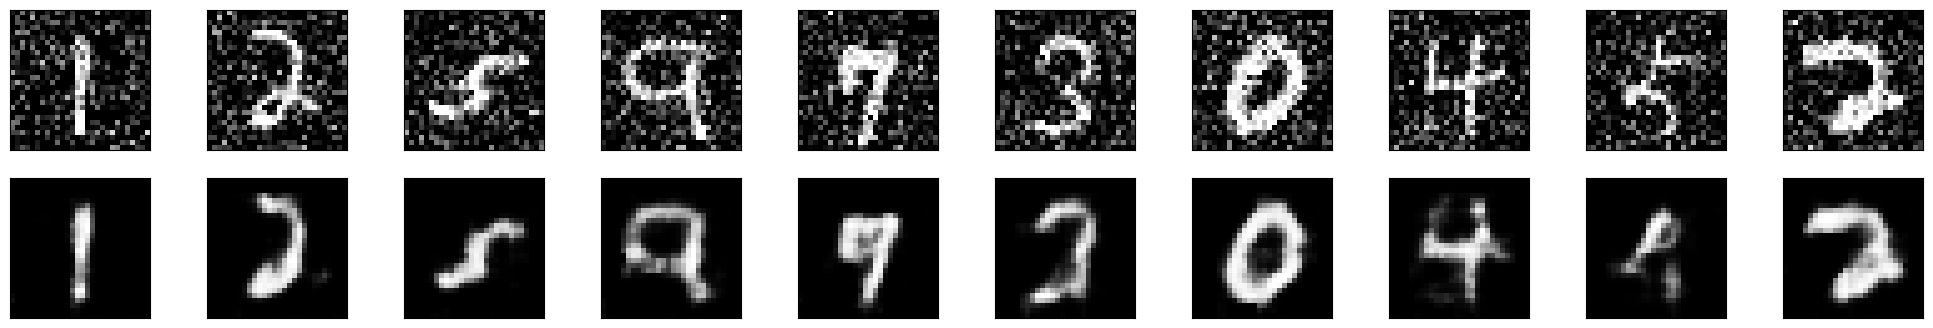

In [ ]:
images, labels = next(iter(dataloader))  # Отримуємо наступну партію даних для оцінки.

eval_noise_factor = 0.3  # Визначаємо фактор шуму для оцінки.

# Додаємо випадковий шум до вхідних зображень для оцінки.
noisy_imgs = images + eval_noise_factor * torch.randn(*images.shape)
noisy_imgs = torch.clip(noisy_imgs, 0., 1.).to(device)  # Обмежуємо значення пікселів у діапазоні [0, 1] та переміщуємо на пристрій.

output = model(noisy_imgs)  # Отримуємо відновлені зображення шляхом виклику моделі для шумних зображень.
noisy_imgs = noisy_imgs.detach().cpu().numpy()  # Перетворюємо тензори у масиви NumPy.
output = output.view(output.size(0), 1, 28, 28)
output = output.detach().cpu().numpy()

# Візуалізуємо оригінальні та відновлені зображення.
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25, 4))
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap="gray")  # Відображаємо зображення у відповідному підпросторі.
        ax.get_xaxis().set_visible(False)  # Вимикаємо підписи по осі x.
        ax.get_yaxis().set_visible(False)  # Вимикаємо підписи по осі y.

### Variational Autoencoders

<center><img src="https://drive.google.com/uc?id=1UjSoyfTrU_0m6w1QZ16kt23nLkjPvm3n"></center>

Стандартні та варіаційні автоенкодери вчаться представляти вхідні дані лише в стиснутій формі, що називається латентним простором або вузьким місцем.

Латентний простір в контексті Autoencoder (автоенкодер) є однією з ключових концепцій цієї нейронної мережі. Латентний простір - це низка векторів, яка представляє собою внутрішнє представлення даних, зазвичай з меншою кількістю вимірів, ніж вхідні дані.

Латентний простір може бути корисним для багатьох завдань, таких як зменшення розмірності даних, виділення важливих ознак або генерація нових прикладів, які подібні до вхідних даних. Він також може служити основою для подальшого розширення і використання в інших моделях глибокого навчання. Латентний простір допомагає відокремити інформацію від шуму та виділити важливі аспекти даних, що сприяє поліпшенню різних завдань у машинному навчанні.

Таким чином, латентний простір, утворений після навчання моделі, не обов’язково є безперервним і, по суті, може бути нелегким для інтерполяції.

Наприклад, ось що варіаційний автоенкодер дізнається з вхідних даних:

<center><img src="https://drive.google.com/uc?id=1UhbWiIluK0U6VA5t29R-F0cZUQANxQ-W"></center>

Хоча ці атрибути пояснюють зображення та можуть бути використані для реконструкції зображення зі стисненого прихованого простору, вони не дозволяють виражати приховані атрибути ймовірнісним способом.

Варіаційні автоенкодери мають справу з цією конкретною темою та виражають свої латентні атрибути у вигляді розподілу ймовірностей, що призводить до формування безперервного латентного простору, який можна легко дискретизувати та інтерполювати.

При подачі тих самих вхідних даних варіаційний автокодер створюватиме латентні атрибути таким чином:

<center><img src="https://drive.google.com/uc?id=1UgWm-bekk6p7mf6GVE-Kva8qfyIO-86L"></center>

Потім латентні атрибути вибираються зі сформованого латентного розподілу та подаються в декодер, реконструюючи вхідні дані.

Мотивацію вираження прихованих атрибутів як розподілу ймовірностей можна дуже легко зрозуміти за допомогою статистичних виразів.

Ось як це працює — ми прагнемо визначити характеристики латентного вектора $z$, який реконструює вихідні дані за певних вхідних даних. По суті, ми хочемо вивчити характеристики латентного вектора за певного виходу $x[p(z|x)]$.

Хоча математично оцінити розподіл стає неможливо, набагато простішим і легшим варіантом є створення параметризованої моделі, яка може оцінити розподіл для нас. Він робить це шляхом мінімізації розбіжності KL (Kullback-Leibler) між оригінальним розподілом і нашим параметризованим.

Виражаючи параметризований розподіл як $q$, ми можемо зробити висновок про можливі приховані атрибути, які використовуються в реконструкції зображення.

Припускаючи, що попередній $z$ є багатовимірною моделлю Гаусса, ми можемо побудувати параметризований розподіл як такий, що містить два параметри, середнє значення та дисперсію. Відповідний розподіл потім дискретизується та подається в декодер, який потім переходить до реконструкції вхідних даних із точок вибірки.

Але хоча теоретично це здається легким, це стає неможливим, оскільки зворотне поширення не може бути визначено для процесу випадкової вибірки, яка виконується перед подачею даних у декодер.

Щоб подолати цю перешкоду, ми використовуємо трюк перепараметризації — вміло визначений спосіб обійти процес вибірки з нейронної мережі.

У трюку з перепараметризацією ми випадково вибираємо значення $\epsilon$ з одиничного Гауса, а потім масштабуємо його за прихованою дисперсією розподілу σ і зміщуємо його на середнє значення $\mu$ того самого.

Тепер ми залишили позаду процес вибірки як щось, що виконується за межами того, що обробляє конвеєр зворотного поширення, а вибіркове значення $\epsilon$ діє як ще один вхідний сигнал для моделі, який подається у вузьке місце.

<center><img src="https://drive.google.com/uc?id=1UeziWy_4QJSd8kTMyfZRlrAkgiaR5jPg"></center>

Таким чином, варіаційний автоенкодер дозволяє нам вивчати плавне представлення латентного стану вхідних даних.

Щоб навчити VAE, ми використовуємо дві функції втрат: втрати при реконструкції та розбіжність KL.

У той час як втрати при реконструкції дозволяють розподілу правильно описувати вхідні дані, зосереджуючись лише на мінімізації втрат при реконструкції, мережа вивчає дуже вузькі розподіли — схожі на дискретні латентні атрибути.

Втрата розбіжності KL заважає мережі вивчати вузькі розподіли та намагається наблизити розподіл до одиничного нормального розподілу.

Узагальнену функцію втрат можна виразити як:

$$ L = |x - \hat{x}| + \beta \sum_i \operatorname{KL} (q_i(z|x) || \mathcal{N}(0,1)) $$

Де $N$ позначає нормальний одиничний розподіл, а $\beta$ позначає ваговий коефіцієнт.

Основне використання варіаційних автоенкодерів можна побачити в генеративному моделюванні.

Вибірка з навченого латентного розподілу та передача результату в декодер може призвести до генерації даних у автоенкодері.

In [6]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int, hidden_dims: list = None) -> None:
        super().__init__()

        self.latent_dim = latent_dim  # Визначаємо розмірність латентного простору.

        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]  # За замовчуванням визначаємо розмірності прихованих шарів.

        # Побудова енкодера
        modules = []
        for h_dim in hidden_dims:
            # Додаємо послідовність згорткового шару, шару нормалізації та функції активації LeakyReLU.
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim, kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim  # Оновлюємо кількість вхідних каналів для наступного шару.
        self.encoder = nn.Sequential(*modules)  # Збираємо енкодер зі створених модулів.
        self.fc_mu = nn.Linear(hidden_dims[-1] * 4, latent_dim)  # Лінійний шар для вихідного значення mu.
        self.fc_var = nn.Linear(hidden_dims[-1] * 4, latent_dim)  # Лінійний шар для вихідного значення log_var.

        # Побудова декодера
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)
        hidden_dims.reverse()  # Реверсуємо розмірності прихованих шарів для декодера.
        modules = []
        for i in range(len(hidden_dims) - 1):
            # Додаємо послідовність транспонованого згорткового шару, шару нормалізації та функції активації LeakyReLU.
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1], kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*modules)  # Збираємо декодер зі створених модулів.
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(hidden_dims[-1], hidden_dims[-1], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(hidden_dims[-1]),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_dims[-1], out_channels=3, kernel_size= 3, padding=1),
            # nn.Tanh(),
            nn.Sigmoid(),
        )  # Фінальний шар декодера для отримання відновлених зображень.

    def encode(self, inputs):
        result = self.encoder(inputs)  # Прямий прохід через енкодер.
        result = torch.flatten(result, start_dim=1)  # Розгортаємо результат перед подачею у лінійний шар.

        # Розділяємо результат на компоненти mu та var латентного гаусового розподілу.
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        result = self.decoder_input(z)  # Подача латентного вектора у лінійний шар декодера.
        result = result.view(-1, 512, 2, 2)  # Розгортання результату перед подачею у декодер.
        result = self.decoder(result)  # Прямий прохід через декодер.
        result = self.final_layer(result)  # Прямий прохід через фінальний шар декодера.
        return result

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Обчислюємо стандартне відхилення з логарифму дисперсії.
        eps = torch.randn_like(std)  # Генеруємо випадковий шум.
        return eps * std + mu  # Повертаємо відновлений латентний вектор.

    def forward(self, inputs):
        mu, log_var = self.encode(inputs)  # Прямий прохід через енкодер для отримання mu та log_var.
        z = self.reparameterize(mu, log_var)  # Перепараметризація для отримання латентного вектора.
        return [self.decode(z), inputs, mu, log_var]  # Повертаємо відновлені зображення, оригінальні зображення, mu та log_var.


In [7]:
def loss_fn(reconstruction, inputs, mu, logvar, kld_weight=1.0):
    # Обчислюємо втрати від відновлення та KL-дивергенцію.
    reconstruction_loss = F.mse_loss(reconstruction, inputs)  # Втрати від відновлення (MSE).
    kld_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim=1), dim=0)  # KL-дивергенція.

    # Повна втрата обчислюється як сума втрат від відновлення та KL-дивергенції з вагою kld_weight.
    loss = reconstruction_loss + kld_weight * kld_loss

    # Повертаємо словник зі значеннями втрат та їх компонентами для моніторингу.
    return {"loss": loss, "reconstruction": reconstruction_loss.item(), "kld": kld_loss.item()}


In [8]:
class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.

    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """

    def _check_integrity(self) -> bool:
        return True

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Визначаємо пристрій для обчислень: CUDA, якщо доступний, або CPU.
batch_size = 64  # Визначаємо розмір пакету.
num_workers = os.cpu_count() // 2  # Визначаємо кількість робочих процесів для завантаження даних.
input_size = (64, 64)  # Визначаємо розмір вхідних зображень.

# Створюємо набори даних для навчання та тестування з використанням MyCelebA.
train = MyCelebA(
    "/content",
    split="train",
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Випадкове горизонтальне відображення.
        transforms.CenterCrop(148),  # Вирізання центральної області зображення.
        transforms.Resize(input_size),  # Зміна розміру зображення.
        transforms.ToTensor(),  # Конвертація зображення у тензор.
    ]),
    download=False
)
test = MyCelebA(
    "/content",
    split="test",
    transform=transforms.Compose([
        transforms.CenterCrop(148),  # Вирізання центральної області зображення.
        transforms.Resize(input_size),  # Зміна розміру зображення.
        transforms.ToTensor(),  # Конвертація зображення у тензор.
    ]),
    download=False,
)

# Створюємо завантажувачі даних для навчання та тестування.
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False)

print("Train:", len(train), len(train_loader))  # Виводимо інформацію про розмір набору даних для навчання та його завантажувач.
print(" Test:", len(test), len(test_loader))  # Виводимо інформацію про розмір набору даних для тестування та його завантажувач.


Train: 162770 2543
 Test: 19962 312


In [10]:
model = VariationalAutoEncoder(in_channels=3, latent_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [11]:
@torch.inference_mode()
def sample_images(num_images, model, device):
    model.eval()  # Переводимо модель у режим оцінювання.
    z = torch.randn(num_images, model.latent_dim, device=device)  # Генеруємо випадковий латентний вектор.
    samples = model.decode(z).detach().cpu().permute(0, 2, 3, 1).numpy()  # Відтворюємо зображення з латентних векторів.
    return samples


def plot_samples(samples):
    n_samples = samples.shape[0]  # Отримуємо кількість зразків.
    fig, axes = plt.subplots(ncols=n_samples, sharex=True, sharey=True, figsize=(25, 4))  # Створюємо фігуру та вісі.
    for i in range(n_samples):
        ax = axes[i]  # Вибираємо поточний підграфік.
        sample_image = samples[i]  # Отримуємо поточне зображення.
        ax.imshow(sample_image, cmap="gray")  # Відображаємо зображення на підграфіку.
        ax.get_xaxis().set_visible(False)  # Вимикаємо підписи по осі x.
        ax.get_yaxis().set_visible(False)  # Вимикаємо підписи по осі y.
    plt.show()  # Відображаємо фігуру з зображеннями.

training: 100%|███████████| 2543/2543 [03:55<00:00, 10.79it/s, loss 0.023, recon: 0.018, kld 21.319]
Epoch  1| 	Training Loss: 0.027769


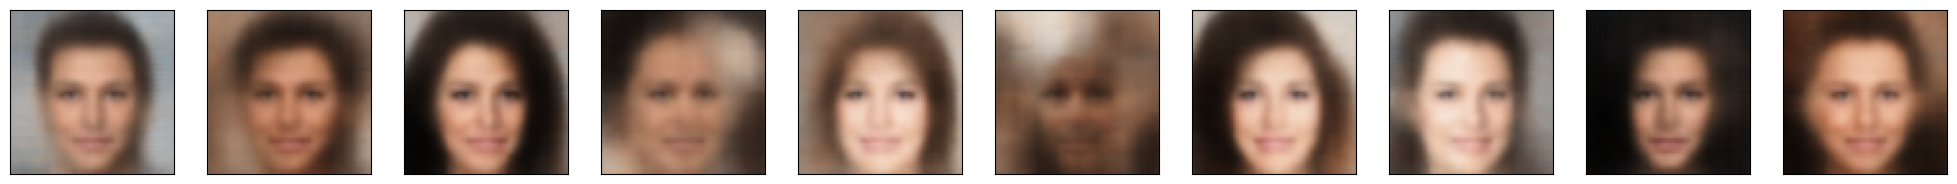

training: 100%|███████████| 2543/2543 [03:46<00:00, 11.24it/s, loss 0.021, recon: 0.015, kld 23.795]
Epoch  2| 	Training Loss: 0.021945


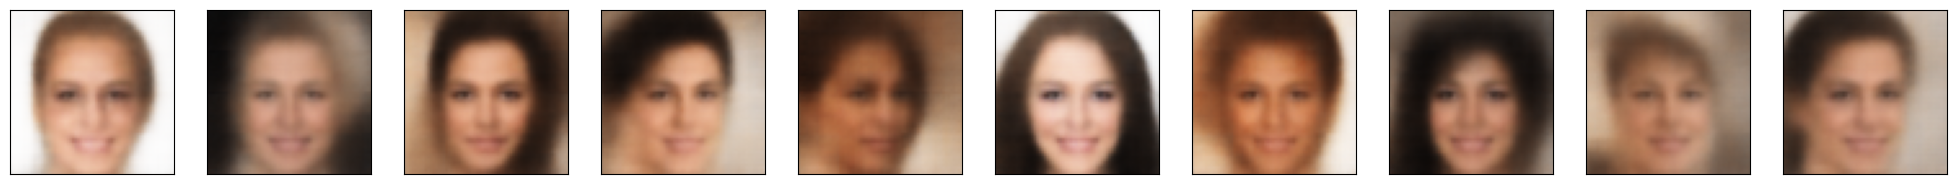

training: 100%|███████████| 2543/2543 [03:53<00:00, 10.89it/s, loss 0.021, recon: 0.015, kld 24.082]
Epoch  3| 	Training Loss: 0.021306


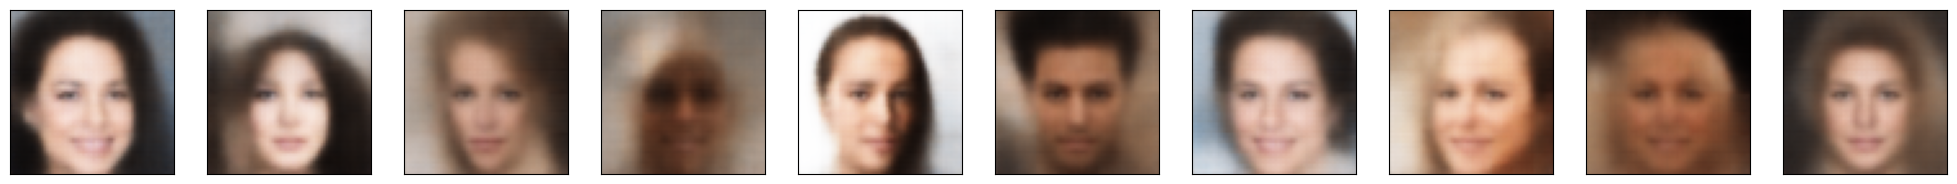

training: 100%|███████████| 2543/2543 [04:02<00:00, 10.49it/s, loss 0.021, recon: 0.015, kld 25.392]
Epoch  4| 	Training Loss: 0.020966


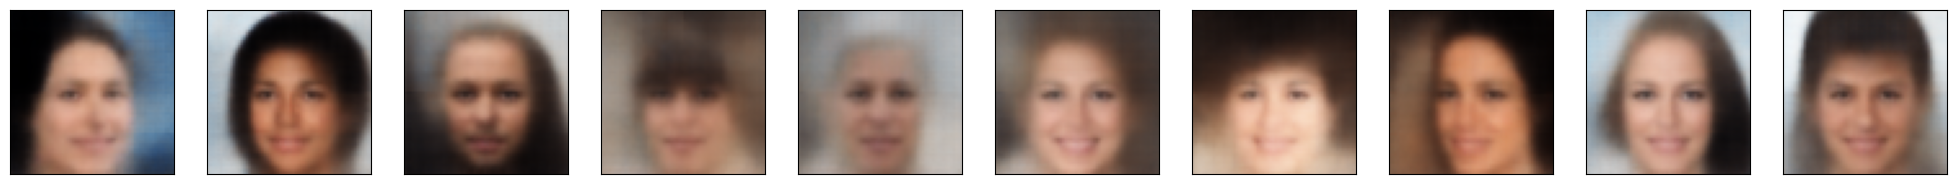

training:  17%|██          | 426/2543 [00:40<03:20, 10.55it/s, loss 0.021, recon: 0.014, kld 24.777]


KeyboardInterrupt: 

In [12]:
num_epochs = 40  # Визначаємо кількість епох навчання.

for epoch in range(num_epochs):
    train_loss = 0.0  # Ініціалізуємо втрати для навчання на поточній епохі.

    with tqdm(total=len(train_loader), desc="training", file=sys.stdout, ncols=100) as progress:
        model.train()  # Переводимо модель у режим навчання.
        for data in train_loader:
            images, _ = data
            images = images.to(device)  # Переміщуємо дані на пристрій.

            optimizer.zero_grad()  # Обнуляємо градієнти попередніх кроків.
            outputs = model(images)  # Отримуємо виходи моделі.

            loss = loss_fn(*outputs, kld_weight=0.00025)  # Обчислюємо втрати.
            loss["loss"].backward()  # Обчислюємо градієнти втрат.
            optimizer.step()  # Виконуємо оптимізаційний крок.

            progress.set_postfix_str("loss {:.3f}, recon: {:.3f}, kld {:.3f}".format(loss["loss"].item(), loss["reconstruction"], loss["kld"]))

            train_loss += loss["loss"].item()  # Додаємо втрати на поточному пакеті.

            progress.update(1)  # Оновлюємо прогрес-бар.

    train_loss = train_loss / len(train_loader)  # Обчислюємо середні втрати для епохи.
    print("Epoch {:2d}| \tTraining Loss: {:.6f}".format(epoch + 1, train_loss))  # Виводимо втрати для поточної епохи.

    model.eval()  # Переводимо модель у режим оцінювання.
    samples = sample_images(10, model, device)  # Генеруємо приклади зображень за допомогою моделі.
    plot_samples(samples)  # Візуалізуємо приклади зображень.
